In [1]:
import pandas as pd
from pathlib import Path
from src.data import CENTERS
from src.config import lesion_level_labels_csv, dmtr_csv
from sklearn.linear_model import LogisticRegression

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')
dmtr = pd.read_csv(dmtr_csv).set_index('id')

save_folder = Path('/mnt/c/Users/user/data/results_dl_response')
target = 'response'

results = []
for center in CENTERS:

    # training recalibrator on deep learning predictions made on training set
    dl_training_preds = pd.read_csv(save_folder / center / 'dl_training_preds.csv').set_index('Unnamed: 0').sum(axis=1)
    dl_training_preds = dl_training_preds.to_frame().join(lesion_fu.patient).rename(columns={0:'training_preds'})
    dl_training_preds = dl_training_preds.groupby('patient').training_preds.min().to_frame().join(dmtr[[target]]).dropna()

    recalibrator = LogisticRegression()
    recalibrator.fit(dl_training_preds[['training_preds']], dl_training_preds[target])

    # recalibrate deep learning predictions on test set
    dl_test_preds = pd.read_csv(save_folder / center / 'dl_test_preds.csv').set_index('Unnamed: 0').mean(axis=1)
    dl_test_preds = dl_test_preds.to_frame().join(lesion_fu.patient).rename(columns={0:'uncalibrated_dl_preds'})
    dl_test_preds = dl_test_preds.groupby('patient').uncalibrated_dl_preds.min().to_frame()

    dl_test_preds['calibrated_dl_preds'] = recalibrator.predict_proba(dl_test_preds)[:,1]

    # add raw clinical predictions to output file
    clinical_preds = pd.read_csv(save_folder / center / 'clinical_test_preds.csv').set_index('id').rename(columns={'0':'clinical_preds'})
    test_preds = dl_test_preds.join(clinical_preds) 
    # test_preds = clinical_preds

    # fit clinical + deep learning model on predictions of both models on train set
    clinical_training_preds = pd.read_csv(save_folder / center / 'clinical_training_preds.csv').set_index('id').rename(columns={'0':'clinical_preds'})
    training_preds = clinical_training_preds.join(dl_training_preds).dropna()

    combination_model = LogisticRegression()
    combination_model.fit(training_preds.drop(columns=[target]), training_preds[target])

    test_preds = test_preds.dropna()

    combination_test_preds = combination_model.predict_proba(test_preds[['uncalibrated_dl_preds','clinical_preds']])[:,1]
    test_preds['combination_preds'] = combination_test_preds

    results.append(test_preds)

results = pd.concat(results).join(dmtr[[target,'center']])
results.to_csv(save_folder / 'predictions.csv')

2023-05-17 15:40:48,943 - Created a temporary directory at /tmp/tmpdszggav9
2023-05-17 15:40:48,944 - Writing /tmp/tmpdszggav9/_remote_module_non_scriptable.py


/tmp/ipykernel_1991/632710056.py:8: DtypeWarning: Columns (1,27,29,175,229,234,249,259,275,281,313,318,351,386,393,440,488,496,538,547,550,579,581,582,583,584,585,587,588,589,599,600,602,603,604,605,610,781,785,786,809,813,814,816,817,820,821,824,906,907,909,910,911,913,916,940,941,943,944,945,952,953,955,956,957,958,959,961,962,963,964,965,967,968,969,970,971,973,974,975,976,989,990,992,993,994,995,996,998,999,1000,1001,1002,1004,1005,1006,1007,1008,1010,1011,1012,1016,1026,1030,1033,1045,1048) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- uncalibrated_dl_preds
Feature names seen at fit time, yet now missing:
- training_preds

  warnings.warn(message, FutureWarning)
/ho

In [77]:
import pandas as pd
from tableone import TableOne
from pathlib import Path

save_folder = Path('/mnt/c/Users/user/data/results_dl_dcb2')
results = pd.read_csv(save_folder / 'predictions.csv')

clinical_predictors = pd.read_csv('/mnt/c/Users/user/data/tables/clinical_predictors.csv').set_index('id')
clinical = results.set_index('patient').join(clinical_predictors.drop(columns=['dcb','center'])).join(dmtr[['Age','Sex','typmel','Stage','Therapy','Best overall response','fu_OS','event_OS','fu_PFS','event_PFS']])

clinical = clinical.rename(
    columns={
        'locafmetlever':'Liver metastases',
        'brain_metastasis':'Brain metastases',
        'no_affected_organs':'No. of affected organs',
        'typmel':'Melanoma type',
        'WHO':'ECOG performance status',
        'dcb':'Clinical benefit',
        'response':'Objective response'
    }
).replace({
    'Melanoma type':{
        1:'Superficial spreading',
        2:'Nodulair',
        3:'Acrolentiginous',
        4:'Lentigo maligna',
        5:'Desmoplastic',
        7:'Other',
        9:'Missing',
        float('nan'):'Missing'
    }
})

table = TableOne(
    clinical,
    columns=[
        'Age',
        'Sex',
        'Therapy',
        'Stage',
        # 'Melanoma type',
        'ECOG performance status',
        'Brain metastases',
        'Liver metastases',
        'LDH',
        'No. of affected organs',
        'Clinical benefit',
        'Objective response',
        'Best overall response'
    ],
    order={
        'LDH':[
            'normal',
            'elevated',
            '>2x ULN',
            'missing'
        ],
        'Brain metastases':[
            'absent',
            'asymptomatic',
            'symptomatic',
            'missing'
        ],
        'Liver metastases':[
            'absent',
            'present',
            'missing'
        ],
        'Best overall response':[
            'Complete response',
            'Partial response',
            'Stable disease',
            'Progressive disease',
            'Death'
        ]
    },
    nonnormal=['Age']
    # pval=True
)
table#.to_csv('/mnt/c/Users/user/Desktop/table1_dl_ct.csv')

Missing           Overall
n                                                                           730
Age, median [Q1,Q3]                                         0  68.0 [58.0,75.0]
Sex, n (%)                     Female                       0        285 (39.0)
                               Male                                  445 (61.0)
Therapy, n (%)                 Anti-PD1                     0        458 (62.7)
                               Ipilimumab & Nivolumab                272 (37.3)
Stage, n (%)                   IIIC                         6          28 (3.9)
                               M1a                                     56 (7.7)
                               M1b                                   114 (15.7)
                               M1c                                   344 (47.5)
                               M1d                                   182 (25.1)
ECOG performance status, n (%) 0                            0        356 (48.8)
                               1                                     271 (37.1)
                               2-4                                    73 (10.0)
                               missing                                 30 (4.1)
Brain metastases, n (%)        absent                       0        497 (68.1)
                               asymptomatic                           94 (12.9)
                               symptomatic                            88 (12.1)
                               missing                                 51 (7.0)
Liver metastases, n (%)        absent                       0        471 (64.5)
                               present                               224 (30.7)
                               missing                                 35 (4.8)
LDH, n (%)                     normal                       0        459 (62.9)
                               elevated                              199 (27.3)
                               >2x ULN                                 62 (8.5)
                               missing                                 10 (1.4)
No. of affected organs, n (%)  <3                           0        542 (74.2)
                               >2                                    188 (25.8)
Clinical benefit, n (%)        0.0                          2        310 (42.6)
                               1.0                                   418 (57.4)
Objective response, n (%)      0.0                          0        357 (48.9)
                               1.0                                   373 (51.1)
Best overall response, n (%)   Complete response           33         94 (13.5)
                               Partial response                      254 (36.4)
                               Stable disease                        113 (16.2)
                               Progressive disease                   229 (32.9)
                               Death                                    6 (0.9)
                               Lost to follow up                        1 (0.1)

In [81]:
results = results.dropna(subset=['dcb'])

In [93]:
results.columns

Index(['patient', 'uncalibrated_dl_preds', 'calibrated_dl_preds',
       'clinical_preds', 'combination_preds', 'dcb', 'center'],
      dtype='object')

In [96]:
from sklearn.metrics import roc_auc_score

predictor1 = 'clinical_preds'
predictor2 = 'combination_preds'

def auc_diff(predictor1, predictor2, subset):
    auc1 = roc_auc_score(subset[target], subset[predictor1])
    auc2 = roc_auc_score(subset[target], subset[predictor2])

    return auc1 - auc2

center_vs_auc = {}
center_vs_std = {}

for center in CENTERS:
    subset = results[results.center == center]

    center_vs_auc[center] = auc_diff(predictor1, predictor2, subset)
    
    bootstrapped_aucs = []
    for _ in range(1000):
        bootstrap = subset.sample(len(subset), replace=True)
        diff = auc_diff(predictor1, predictor2, bootstrap)
        bootstrapped_aucs.append(diff)

    center_vs_std[center] = np.std(bootstrapped_aucs)



In [95]:
pd.DataFrame([center_vs_auc, center_vs_std], index=['diff','std']).transpose().to_csv('/home/rens/repos/premium_dl_ct/tables/clinical_vs_combination.csv')

In [54]:
dmtr.loc['PREM_ZU_037']['followup']

"[(5.0, Timestamp('2019-07-04 00:00:00')), (5.0, Timestamp('2019-07-04 00:00:00'))]"

In [55]:
import pandas as pd
from src.config import lesion_level_labels_csv, dmtr_csv

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';')
dmtr = pd.read_csv(dmtr_csv).set_index('id')

print('Available:', (~lesion_fu.lesion_benefit.isna()).sum())
print('Radboud: ', lesion_fu.center.value_counts()['radboud'])
not_radboud = lesion_fu[lesion_fu.center != 'radboud']
not_radboud_dmtr = dmtr.loc[not_radboud.patient.unique()]
early_progressors = not_radboud_dmtr[(not_radboud_dmtr.fu_PFS.apply(lambda x: int(x.split()[0]) if type(x) == str else float('nan')) < 90) & (not_radboud_dmtr.event_PFS)].index
lost_due_to_early_progression = not_radboud[not_radboud.patient.isin(early_progressors) & not_radboud.last_fu.isna()]

print('Due to early progression:', len(lost_due_to_early_progression))
not_due_to_early_progression = not_radboud[~not_radboud.lesion.isin(lost_due_to_early_progression.lesion.tolist())]

at_least_one_lesion_with_followup = not_due_to_early_progression.groupby('patient').last_fu.apply(list).apply(lambda x: ~pd.isna(x)).apply(any)
print(
    'Due to outside FOV:', 
    not_due_to_early_progression[not_due_to_early_progression.patient.isin(at_least_one_lesion_with_followup[at_least_one_lesion_with_followup].index)].last_fu.isna().sum()
)

print('Lesion benefit rate: ', lesion_fu[~lesion_fu.last_fu.isna()].lesion_benefit.mean())
print('Lesion response rate: ', lesion_fu[~lesion_fu.last_fu.isna()].lesion_response.mean())

Available: 2128
Radboud:  326
Due to early progression: 264
Due to outside FOV: 15
Lesion benefit rate:  0.7974624060150376
Lesion response rate:  0.5526315789473685


/tmp/ipykernel_1711/1414138779.py:5: DtypeWarning: Columns (1,27,29,175,229,234,249,259,275,281,313,318,351,386,393,440,488,496,538,547,550,579,581,582,583,584,585,587,588,589,599,600,602,603,604,605,610,781,785,786,809,813,814,816,817,820,821,824,906,907,909,910,911,913,916,940,941,943,944,945,952,953,955,956,957,958,959,961,962,963,964,965,967,968,969,970,971,973,974,975,976,989,990,992,993,994,995,996,998,999,1000,1001,1002,1004,1005,1006,1007,1008,1010,1011,1012,1016,1026,1030,1033,1045,1048) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


In [56]:
results = results.dropna(subset=['dcb'])

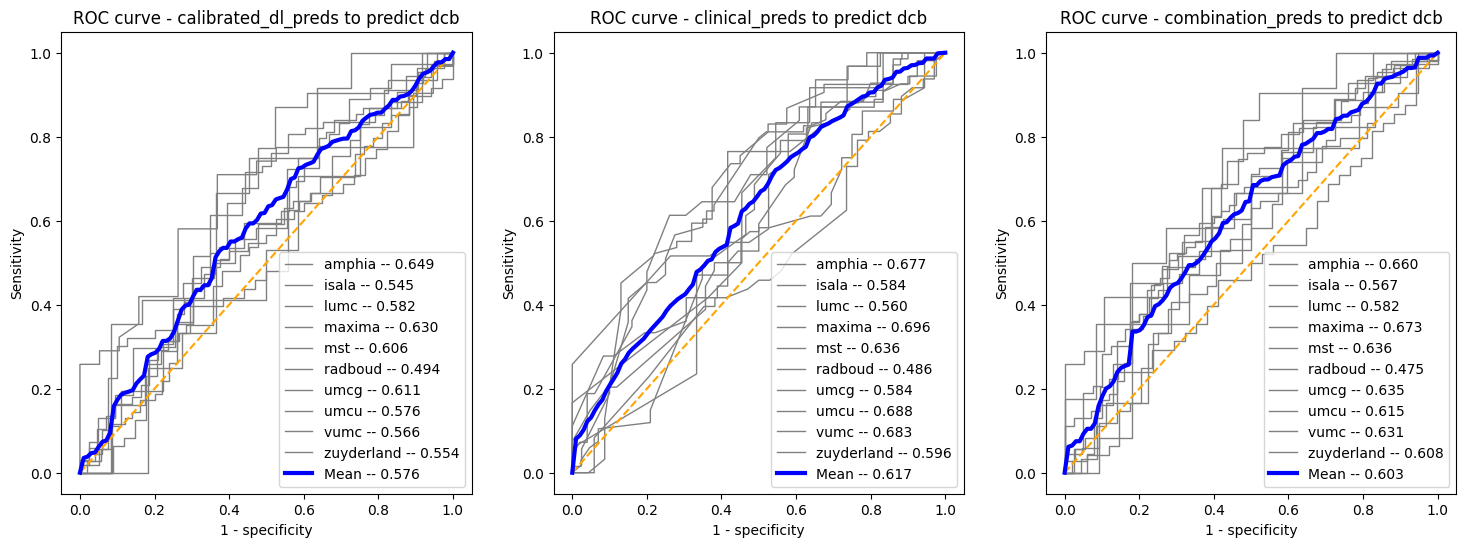

In [57]:
import matplotlib.pyplot as plt
from src.plot_utils import plot_roc, plot_calibration_curve, plot_correlation

fig, ax = plt.subplots(1,3, figsize=(18,6))
plot_roc('calibrated_dl_preds',target,results.dropna(subset=['dcb']),ax[0])
plot_roc('clinical_preds',target,results.dropna(subset=['dcb']),ax[1])
plot_roc('combination_preds',target,results.dropna(subset=['dcb']),ax[2])
fig.show()

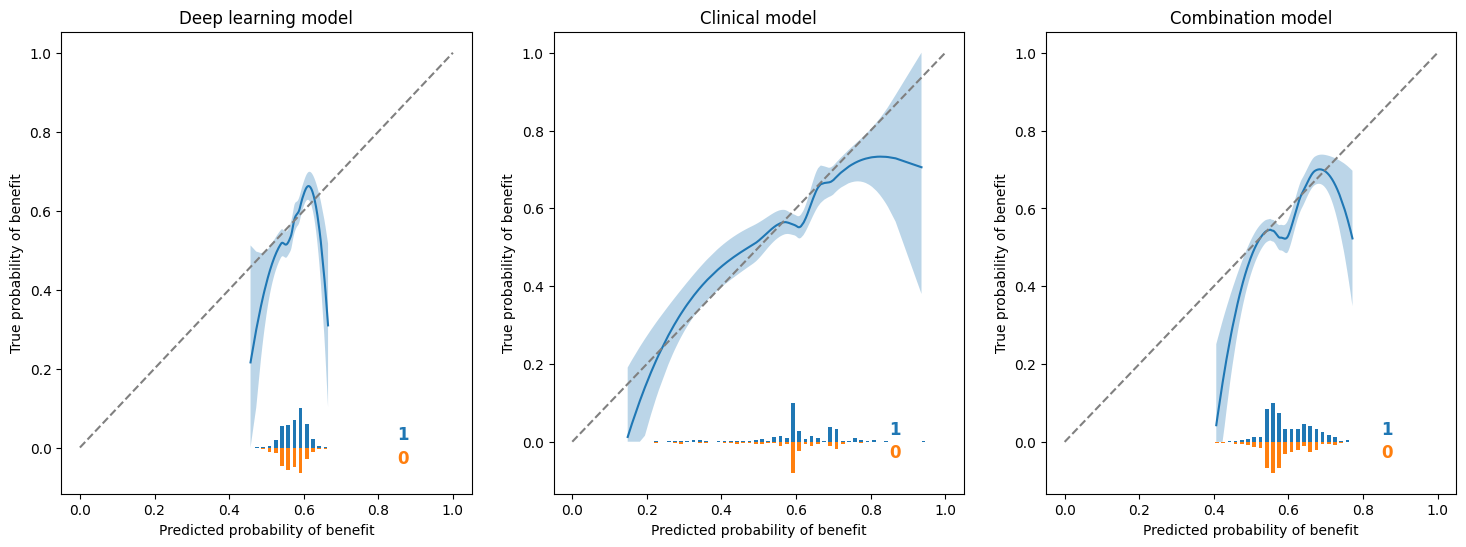

In [58]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].set_title('Deep learning model')
ax[1].set_title('Clinical model')
ax[2].set_title('Combination model')

plot_calibration_curve('calibrated_dl_preds',target,results.dropna(subset=['dcb']),ax[0])
plot_calibration_curve('clinical_preds',target,results.dropna(subset=['dcb']),ax[1])
plot_calibration_curve('combination_preds',target,results.dropna(subset=['dcb']),ax[2])
fig.show()

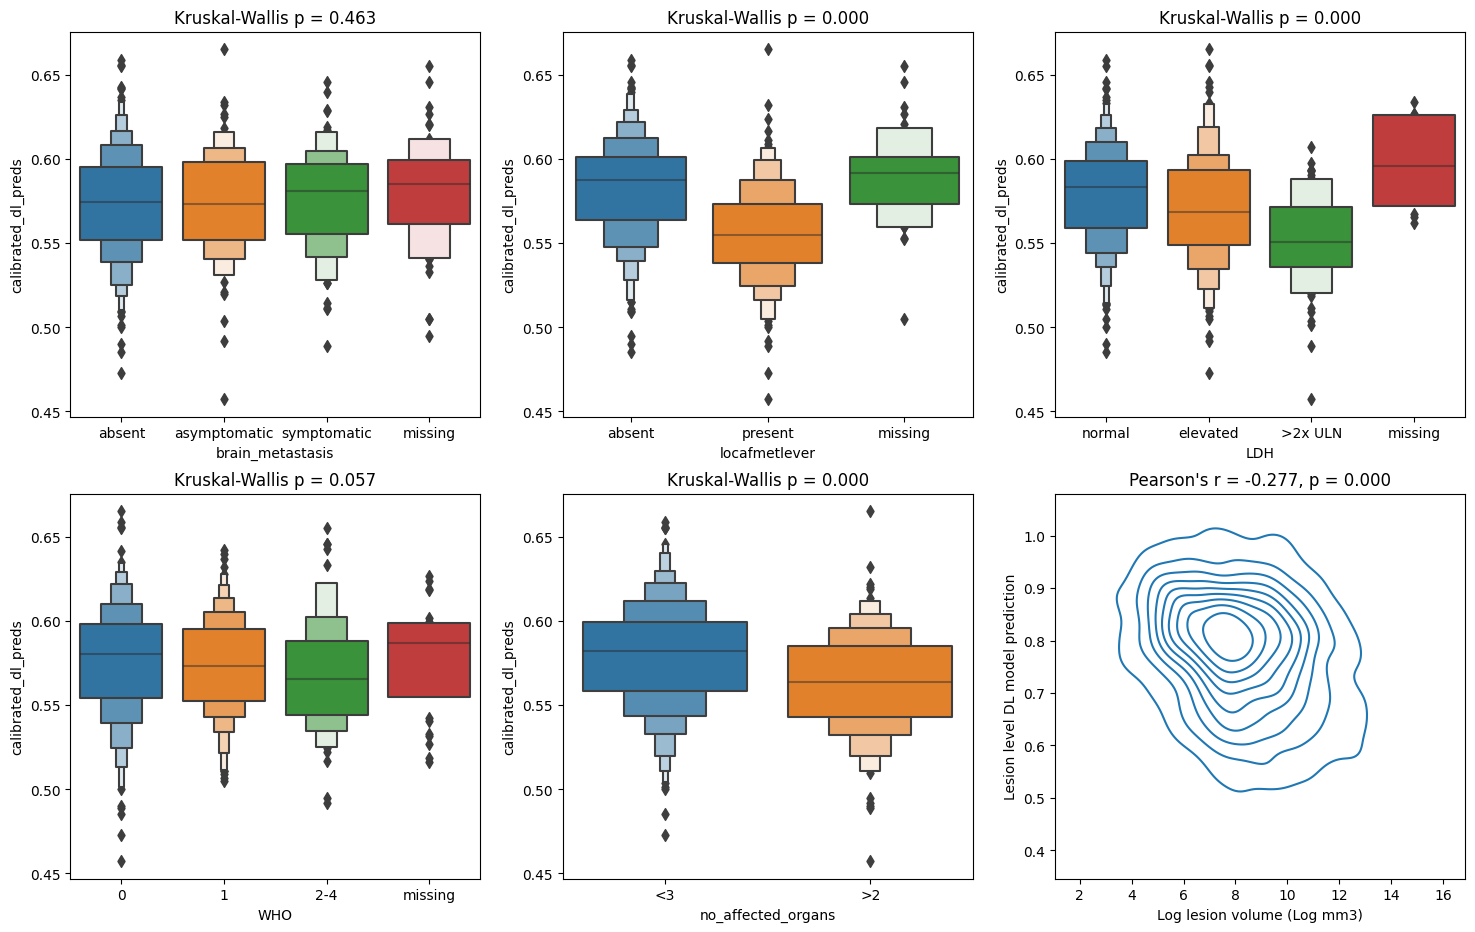

In [62]:
import numpy as np
import seaborn as sn
from scipy.stats import pearsonr
from src.plot_utils import plot_boxplot

clinical_predictors = pd.read_csv('/mnt/c/Users/user/data/tables/clinical_predictors.csv').set_index('id')

clinical_variables = ['brain_metastasis','locafmetlever','LDH','WHO','no_affected_organs']
order = {
    'brain_metastasis':['absent','asymptomatic','symptomatic','missing'],
    'locafmetlever':None,
    'LDH':None,
    'WHO':['0','1','2-4','missing'],
    'no_affected_organs':None
}

results = results.set_index('patient')


fig, ax = plt.subplots(2,3, figsize=(18,11))
for ix in range(5):
    plot_boxplot(
        'calibrated_dl_preds',
        clinical_variables[ix],
        results.join(clinical_predictors[clinical_variables[ix]]), 
        ax=ax[ix // 3, ix % 3],
        order=order[clinical_variables[ix]]
    )

preds= []
for center in CENTERS:
    lesion_preds = pd.read_csv(save_folder / center / 'dl_test_preds.csv').set_index('Unnamed: 0')
    lesion_preds = lesion_preds[lesion_preds.isna().sum(axis=1) == 0]
    preds.append(lesion_preds)
preds = pd.concat(preds).mean(axis=1).to_frame()
radiomics = pd.read_csv('/mnt/c/Users/user/data/tables/radiomics_v4.csv').set_index('Unnamed: 0')
preds = preds.join(radiomics['level1_original_shape_MeshVolume'])

preds = preds.dropna()

x = np.log(preds['level1_original_shape_MeshVolume'].rename('Log lesion volume (Log mm3)'))
y = preds[0].rename('Lesion level DL model prediction')

sn.kdeplot(
    x=x, y=y, 
    ax=ax[1,2]
)

r, p = pearsonr(x, y)
ax[1,2].set_title(f'Pearson\'s r = {r:.3f}, p = {p:.3f}')

fig.show()

In [72]:
from src.eval import TrainedModel, Config, get_fold_vs_run_ids
from src.data import DataModule
from src.config import radiomics_folder, lesion_level_labels_csv
import torch.nn as nn
from pathlib import Path


sweep_id = '8fki21ur'
fold_vs_id = get_fold_vs_run_ids(sweep_id)

test_center = 'umcg'
fold = 0

run_id = fold_vs_id[test_center][fold][1]
model = TrainedModel(run_id, '/dev/zero', fold)

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    
model.model.last_linear = Identity()
model.model.eval()

mock_wandb_config = Config(
    roi_selection_method='crop',
    dim = 3,
    size=182,
    roi_size=142,
    test_center=test_center,
    max_batch_size=6,
    inner_fold=0,
    lesion_target='lesion_benefit',
    sampler='vanilla',
    augmentation_noise_std=0.001
)

dm = DataModule(radiomics_folder, lesion_level_labels_csv, mock_wandb_config)
dm.setup(stage='test')
dl = dm.test_dataloader()

/home/rens/repos/premium_dl_ct/src/eval.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.predictions = pd.Series(name=f"fold_{fold}")
Loading dataset: 100%|██████████| 420/420 [00:00<00:00, 1061849.11it/s]


In [73]:
import pandas as pd

model.model.cuda()

df = pd.DataFrame(columns=[f'feature{f}' for f in range(2048)])

for batch in dl:
    x = batch['img'].cuda()

    y_hat = model.model(x).cpu().detach().numpy()

    for ix, name in enumerate([Path(p).name for p in batch['img_meta_dict']['filename_or_obj']]):
        df.loc[name] = y_hat[ix].tolist()


/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tab:orange
tab:blue


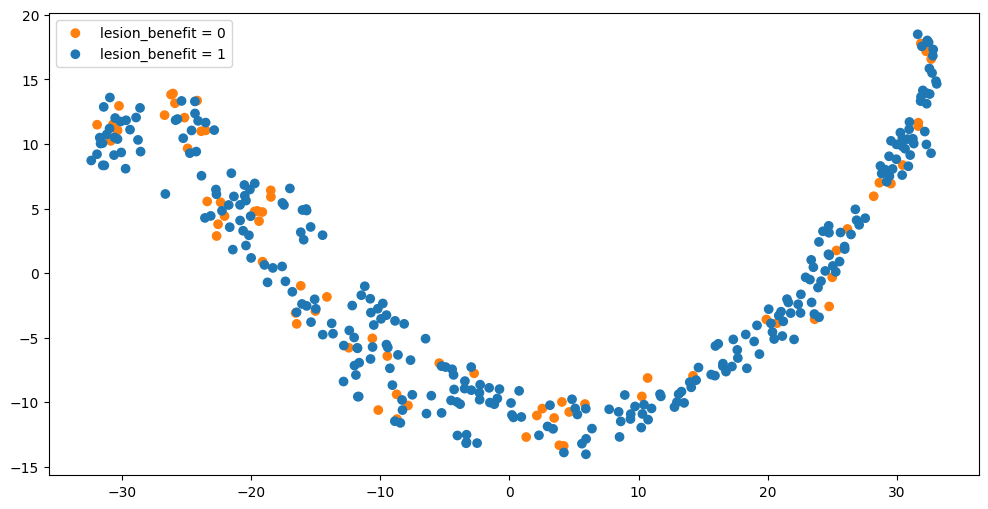

In [74]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')

df = df.join(lesion_fu[['lesion_benefit','organ']])
feature_columns = [f'feature{f}' for f in range(2048)]

tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(df[feature_columns])

groupby = 'lesion_benefit'
colors = {
    0:'tab:orange',
    1:'tab:blue'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

tab:orange
tab:blue
tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


Text(0.5, 1.0, 't-SNE visualization of hidden state colored according to size (red = larger)')

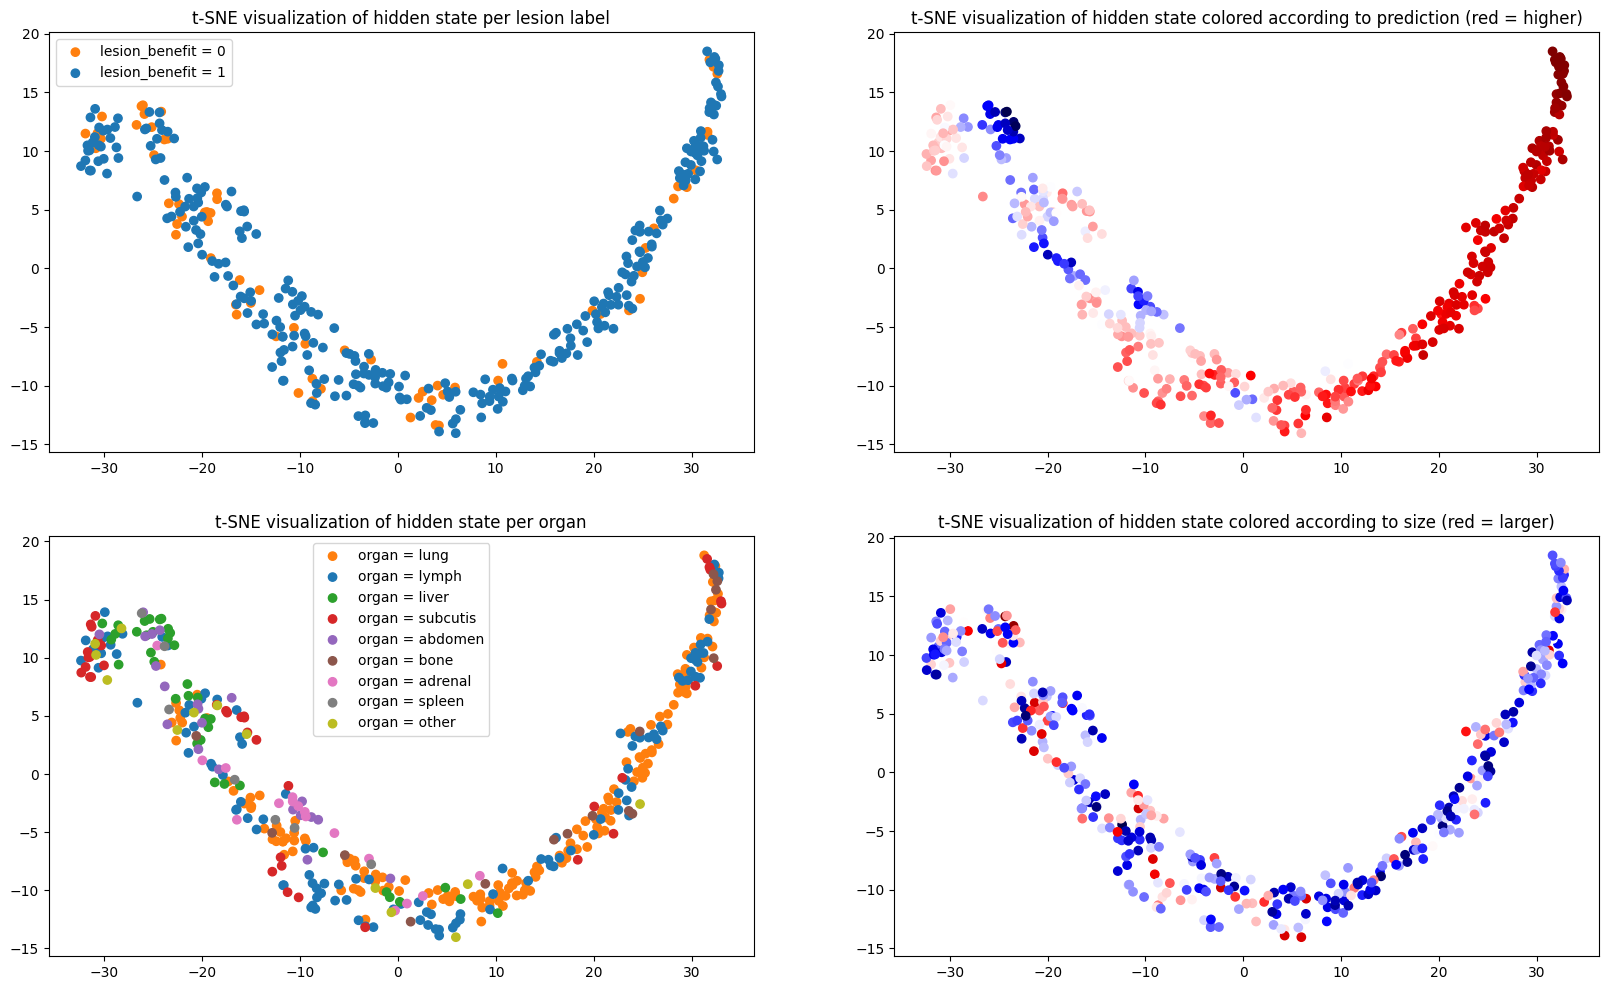

In [75]:
preds = preds.rename(columns={0:'Lesion level DL pred','level1_original_shape_MeshVolume':'Lesion volume'})
df= df.join(preds)

fig, ax = plt.subplots(2,2, figsize=(20,12))

# response
groupby = 'lesion_benefit'
colors = {
    0:'tab:orange',
    1:'tab:blue'
}

for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    ax[0,0].scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
    ax[0,0].legend()
ax[0,0].set_title('t-SNE visualization of hidden state per lesion label')

# prediction
ax[0,1].scatter(tsne_results[:,0], tsne_results[:,1], c=df['Lesion level DL pred'], cmap='seismic')
ax[0,1].set_title('t-SNE visualization of hidden state colored according to prediction (red = higher)')


# organ
groupby = 'organ'
colors = {
    'lung':'tab:orange',
    'lymph':'tab:blue',
    'liver':'tab:green',
    'subcutis':'tab:red',
    'abdomen':'tab:purple',
    'bone':'tab:brown',
    'adrenal':'tab:pink',
    'spleen':'tab:grey',
    'other':'tab:olive'
}
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    ax[1,0].scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
    ax[1,0].legend()
ax[1,0].set_title('t-SNE visualization of hidden state per organ')

# size
ax[1,1].scatter(tsne_results[:,0], tsne_results[:,1], c=np.log(df['Lesion volume']), cmap='seismic')
ax[1,1].set_title('t-SNE visualization of hidden state colored according to size (red = larger)')

In [146]:
results

array([[ 29.675339 , -18.059694 ],
       [-17.212454 ,  11.202942 ],
       [ -4.370813 ,  -3.5426178],
       [ 29.800358 , -23.445562 ],
       [  8.410971 , -10.7885   ],
       [ -3.231174 ,  -6.8828535],
       [ -3.2873287,  -1.4022624]], dtype=float32)

tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


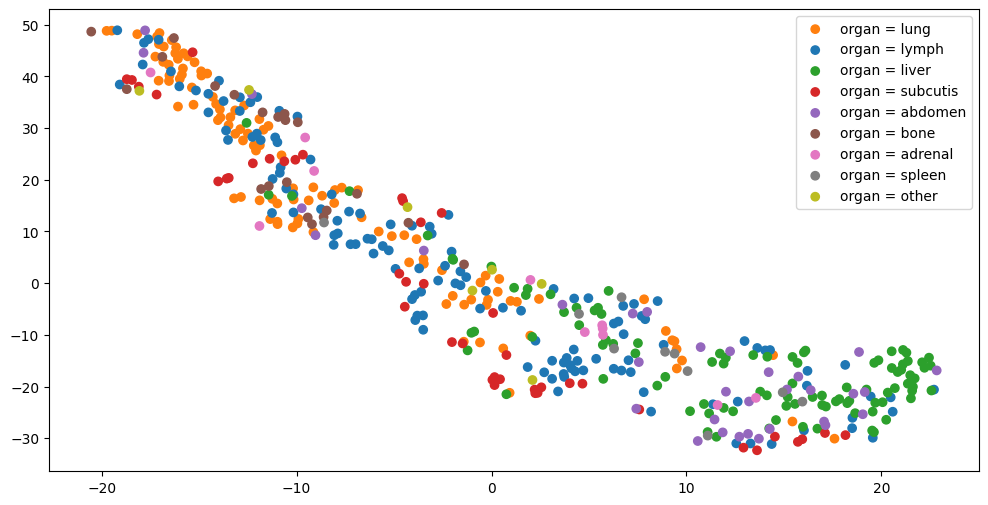

In [110]:
groupby = 'organ'
colors = {
    'lung':'tab:orange',
    'lymph':'tab:blue',
    'liver':'tab:green',
    'subcutis':'tab:red',
    'abdomen':'tab:purple',
    'bone':'tab:brown',
    'adrenal':'tab:pink',
    'spleen':'tab:grey',
    'other':'tab:olive'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

In [14]:
df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature2040,feature2041,feature2042,feature2043,feature2044,feature2045,feature2046,feature2047,organ,lesion_response
PREM_VU_001_0.nii.gz,0.730939,1.008331,1.344875,0.903936,0.654795,0.433566,0.740617,0.604265,0.896499,0.960558,...,0.974196,0.638648,0.674505,0.769862,0.564736,0.662781,0.979482,0.501827,lung,0.0
PREM_VU_001_1.nii.gz,0.639879,0.713176,1.011923,0.691216,0.529022,0.609413,0.533831,0.560095,0.742856,0.744494,...,0.863634,0.431213,0.752792,0.658808,0.571675,0.479370,0.749826,0.305411,lung,1.0
PREM_VU_001_2.nii.gz,0.715957,1.094647,1.591301,1.128813,0.661166,0.338572,0.806004,0.775103,1.027381,0.945923,...,1.034602,0.743686,0.588121,0.572657,0.464448,0.629697,1.264934,0.542293,lung,0.0
PREM_VU_001_3.nii.gz,0.595837,0.904091,0.939884,0.713406,0.630138,0.507923,0.642287,0.438003,1.041659,0.629872,...,1.026959,0.538298,0.653088,0.644846,0.403847,0.395206,0.876113,0.404527,liver,0.0
PREM_VU_001_4.nii.gz,0.490546,0.933198,0.923926,0.670485,0.396492,0.553978,0.391113,0.474696,0.860441,0.678912,...,0.939171,0.515283,0.689837,0.537000,0.427401,0.367626,0.882904,0.317709,liver,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PREM_VU_191_0.nii.gz,0.551178,0.986235,1.150782,0.945265,0.370944,0.465854,0.410937,0.428128,0.973875,0.878926,...,1.088321,0.583703,0.513311,0.626401,0.311970,0.408506,1.196620,0.339012,liver,0.0
PREM_VU_191_1.nii.gz,0.985241,1.395666,1.585444,1.472129,0.629027,0.344755,1.736306,1.005210,0.988522,1.480449,...,0.692206,1.274998,0.432791,0.607330,0.590756,1.267814,1.360458,1.136623,liver,0.0
PREM_VU_191_2.nii.gz,0.573855,1.134709,1.338699,0.936445,0.432585,0.460705,0.425996,0.421923,1.022503,0.865179,...,1.151302,0.652530,0.511297,0.679407,0.407065,0.465093,1.149951,0.469792,abdomen,0.0
PREM_VU_191_3.nii.gz,0.603697,0.982639,1.111274,0.697132,0.584344,0.576339,0.446500,0.601368,0.801606,0.732353,...,0.986924,0.482949,0.721144,0.619855,0.503612,0.427591,1.026074,0.423999,abdomen,0.0


In [36]:
import numpy as np
from monai.data import Dataset
from monai.transforms import (
    Compose, 
    LoadImaged, 
    EnsureChannelFirstd, 
    RandRotated, 
    CenterSpatialCropd,
    RandGaussianNoised,
    SaveImaged
)
from torch.utils.data import DataLoader

data = dm.train_data

t = Compose([
    LoadImaged(keys=['img']),
    EnsureChannelFirstd(keys=['img']),
    RandRotated(
        keys=['img'], 
        range_x=(0,2*np.pi), 
        range_y = (0,2*np.pi), 
        range_z=(0,2*np.pi), 
        prob=1
    ),
    CenterSpatialCropd(keys=['img'], roi_size=(128,128,128)),
    RandGaussianNoised(keys=['img'], prob=1, std=0.001),
    # SaveImaged(
    #     keys=['img'], 
    #     output_dir='/mnt/c/Users/user/data/dl_radiomics/augmented', 
    #     output_ext='.nii.gz',
    #     resample=False,
    #     separate_folder=False,
    # )
])

ds = Dataset(data, t)
dl = DataLoader(ds, batch_size=6)

x = next(iter(dl))

In [37]:
x['img'].shape

(6, 1, 128, 128, 128)

In [25]:
import pandas as pd

df = pd.read_csv("/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv", sep=';')

In [29]:
len(df)

2772

In [8]:
import pandas as pd

df = pd.read_csv('/mnt/c/Users/user/Downloads/wandb_export_2023-01-20T08_15_03.480+01_00.csv')
df = df[df.State == 'finished']

In [9]:
df.columns

Index(['Name', 'Agent', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime',
       'Sweep', 'T_0', 'aggregation_function', 'dim', 'dropout',
       'learning_rate_max', 'lesion_target', 'lr_min', 'max_batch_size',
       'max_epochs', 'model', 'n_forward_per_backwards', 'optimizer',
       'patience', 'patient_target', 'pretrained', 'roi_selection_method',
       'roi_size', 'sampler', 'seed', 'size', 'weight_decay', 'epoch', 'lr',
       'train_auc', 'train_loss', 'train_patient_auc', 'trainer/global_step',
       'valid_auc', 'valid_loss', 'valid_patient_auc'],
      dtype='object')

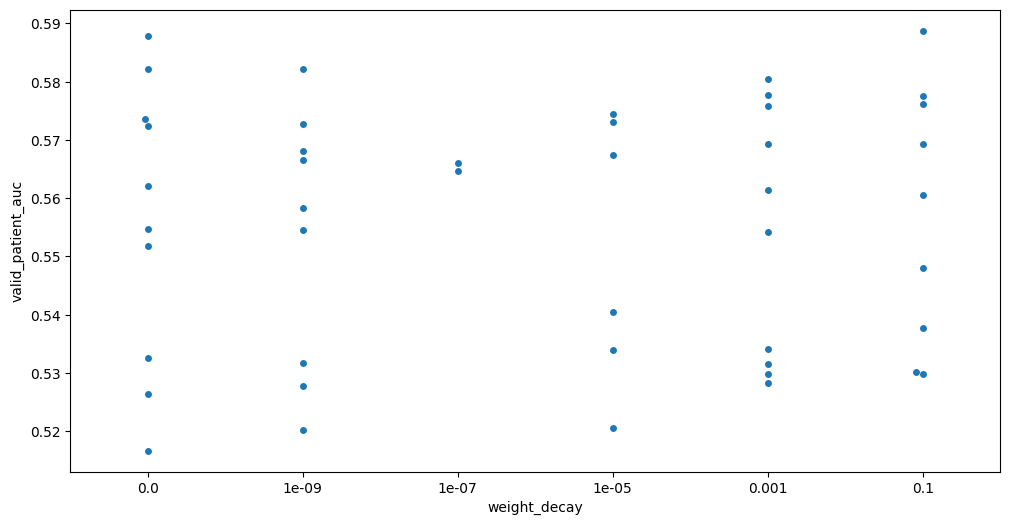

In [10]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(12,6))
sn.swarmplot(data=df, x='weight_decay', y='valid_patient_auc')
plt.show()

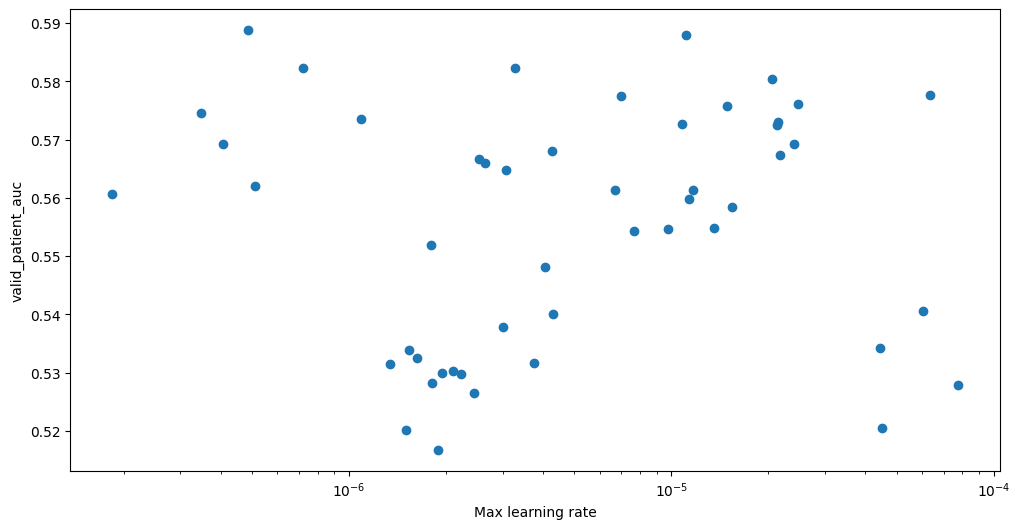

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(df.lr, df.valid_patient_auc)
plt.xlabel('Max learning rate')
plt.ylabel('valid_patient_auc')
plt.xscale('log')
plt.show()

In [48]:
batch = np.array(list(range(32)))


mini_batch_size =32
for ix in range(0, len(batch), mini_batch_size):
    print(batch[ix:ix+mini_batch_size])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [50]:
len(x)

32

In [23]:
new_grad[0,0,0]

array([-9.4738527e-05, -1.0190648e-04, -1.3707948e-04, -1.4512578e-04,
       -1.3249271e-04, -5.2837066e-05, -3.5660356e-05], dtype=float32)

In [24]:
original_grad[0,0,0]

array([-9.4678675e-05, -1.0183325e-04, -1.3698640e-04, -1.4505384e-04,
       -1.3245209e-04, -5.2787924e-05, -3.5580433e-05], dtype=float32)

In [21]:
y_hat.detach().numpy()

array([[0.34611627],
       [0.34112442],
       [0.40652257],
       [0.39151615],
       [0.3430734 ],
       [0.3531861 ]], dtype=float32)

In [22]:
y_hat2.detach().numpy()

array([[0.34611627],
       [0.34112436],
       [0.4065227 ],
       [0.39151615],
       [0.34307343],
       [0.35318622]], dtype=float32)

In [35]:
from pathlib import Path
import numpy as np

dl = dm.val_dataloader()

batches = []
for batch in dl:
    batches.append(np.stack([
        batch['label'].numpy(),
        batch['organ'],
        [Path(f).name for f in batch['img_meta_dict']['filename_or_obj']]
    ], axis=1))

Loading dataset: 100%|██████████| 576/576 [00:00<00:00, 550072.66it/s]


In [32]:
possible = [case['img'].split('/')[-1] for case in dm.train_data]

In [20]:
batch['organ']

['adrenal',
 'bone',
 'liver',
 'liver',
 'liver',
 'lung',
 'lung',
 'lung',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'other',
 'abdomen',
 'abdomen',
 'bone',
 'liver',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'other',
 'subcutis',
 'subcutis']

In [5]:
from src.config import lesion_level_labels_csv, dmtr_csv
import pandas as pd

dmtr = pd.read_csv(dmtr_csv)
lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';')

/tmp/ipykernel_19073/2195945971.py:4: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv)


In [11]:
import numpy as np

np.unique([pt for pt in lesion_fu.patient if not pt in dmtr.id.values])

array(['UMCG_118', 'UMCG_382', 'UMCG_400', 'UMCG_448', 'UMCG_457',
       'UMCG_469', 'UMCG_548', 'UMCG_650'], dtype='<U8')

In [12]:
umcg = pd.read_excel('/mnt/c/Users/user/repos/PREMIUM/code/radiomics_paper/data/raw_dmtr/umcg.xlsx')

In [24]:
umcg[umcg.upn == 'UMCG_656'].ptloc

26385    1.0
26386    1.0
26387    1.0
26388    1.0
26389    1.0
        ... 
26836    1.0
26837    1.0
26838    1.0
26839    1.0
26840    1.0
Name: ptloc, Length: 456, dtype: float64

In [53]:
import pandas as pd

df = pd.read_csv("/mnt/d/premium_data/umcg/umcg_followup (1).csv", sep=';')

In [55]:
df['delta1'] = df['fu1'] / df['baseline']
df['delta2'] = df['fu2'] / df['baseline']
df['delta3'] = df['fu3'] / df['baseline']

In [63]:
last_fus = []
for _, lesion in df.iterrows():
    last_fu = float('nan')
    if not pd.isna(lesion.delta1):
        last_fu = lesion.delta1
    if not pd.isna(lesion.delta2):
        last_fu = lesion.delta2
    if not pd.isna(lesion.delta3):
        last_fu = lesion.delta3
    last_fus.append(last_fu)

df['last_fu'] = last_fus

In [67]:
lesion_response, lesion_benefit = [],[]
for _, lesion in df.iterrows():
    if pd.isna(lesion.last_fu):
        lesion_response.append(float('nan'))
        lesion_benefit.append(float('nan'))
        continue

    if lesion.last_fu < 0.7:
        lesion_response.append(1)
    else: 
        lesion_response.append(0)

    if lesion.last_fu < 1.2:
        lesion_benefit.append(1)
    else: 
        lesion_benefit.append(0)

df['lesion_response'] = lesion_response
df['lesion_benefit'] = lesion_benefit

In [68]:
df

,lesion,name,patient,start_date,scan_date,baseline,fu1,fu2,fu3,delta1,delta2,delta3,last_fu,lesion_response,lesion_benefit
0,UMCG_004abdomen_0.nii.gz,softtissue1,UMCG_004,17-10-2016,30-9-2016,97.0,85.0,NaN,NaN,0.876289,NaN,NaN,0.876289,0.0,1.0
1,UMCG_004abdomen_1.nii.gz,lymph1,UMCG_004,17-10-2016,30-9-2016,20.0,16.0,NaN,NaN,0.800000,NaN,NaN,0.800000,0.0,1.0
2,UMCG_004abdomen_2.nii.gz,lymph2,UMCG_004,17-10-2016,30-9-2016,27.0,49.0,NaN,NaN,1.814815,NaN,NaN,1.814815,0.0,0.0
3,UMCG_004thorax_0.nii.gz,lung1,UMCG_004,17-10-2016,30-9-2016,29.0,32.0,NaN,NaN,1.103448,NaN,NaN,1.103448,0.0,1.0
4,UMCG_004thorax_1.nii.gz,lymph1,UMCG_004,17-10-2016,30-9-2016,44.0,11.0,NaN,NaN,0.250000,NaN,NaN,0.250000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,UMCG_738abdomen_0.nii.gz,subcutis1,UMCG_738,11-4-2017,15-3-2017,10.0,13.0,12.0,9.0,1.300000,1.200000,0.900,0.900000,0.0,1.0
459,UMCG_738abdomen_1.nii.gz,lymph1,UMCG_738,11-4-2017,15-3-2017,21.0,21.0,0.0,NaN,1.000000,0.000000,NaN,0.000000,1.0,1.0
460,UMCG_738abdomen_2.nii.gz,lymph2,UMCG_738,11-4-2017,15-3-2017,19.0,18.0,0.0,NaN,0.947368,0.000000,NaN,0.000000,1.0,1.0
461,UMCG_738abdomen_3.nii.gz,subcutis2,UMCG_738,11-4-2017,15-3-2017,8.0,7.0,6.0,5.0,0.875000,0.750000,0.625,0.625000,1.0,1.0


In [69]:
organ_synonyms = {
    'lung':['lung','pleur','pulm'],
    'liver':['liver'],
    'lymph':['lymph', 'lymoh', 'inguin', 'supraclav'],
    'subcutis':['subcut'],
    'adrenal':['adren'],
    'abdomen':['abd', 'mesent', 'intest', 'perit','mesent','adbom'],
    'bone':['bone', 'os', 'th5', 'ileum'],
    'spleen':['spleen']
}

organs = []
for name in df['name'].tolist():
    name = name.lower()

    found = False
    for organ, synonyms in organ_synonyms.items():
        if any([synonym in name for synonym in synonyms]):
            organs.append(organ)
            found = True
            break

    if not found:
        organs.append('other')
        
df['organ'] = organs

In [71]:
df.to_csv('/mnt/d/premium_data/umcg/lesion_followup_curated.csv')

In [38]:
df.drop(columns=['Unnamed: 0']).to_csv("/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv")

In [24]:
val_dl = dm.val_dataloader()

val_batches = []
for batch in val_dl:
    val_batches.append(
        list(zip(batch['patient'], batch['label'].numpy().tolist()))
    )

Loading dataset: 100%|██████████| 568/568 [00:00<00:00, 596485.90it/s]


In [43]:
from collections import defaultdict

def count_per_patient(batches):
    count = defaultdict(int)
    for batch in batches:
        for case in batch:
            count[case[0]] += 1

    assert max(list(count.values())) <= 5

def no_overlap(train, val):
    train_patients = set()
    for batch in train:
        for case in batch:
            train_patients.add(case[0])

    val_patients = set()
    for batch in val:
        for case in batch:
            val_patients.add(case[0])

    assert train_patients.isdisjoint(val_patients)

count_per_patient(batches)
no_overlap(batches, val_batches)

In [3]:
from src.config import radiomics_folder, lesion_level_labels_csv
import pandas as pd

fu = pd.read_csv(lesion_level_labels_csv, sep=';')

In [4]:
import os

radiomics = pd.read_csv('/mnt/c/Users/user/data/tables/radiomics_v2.csv').set_index('Unnamed: 0')

In [5]:
df = radiomics.join(fu.set_index('lesion'))

In [6]:
from sklearn.preprocessing import StandardScaler

df[radiomics.columns] = StandardScaler().fit_transform(df[radiomics.columns])

In [10]:
df.lesion_response == 1

Unnamed: 0
IM_047_0.nii.gz          True
IM_047_1.nii.gz          True
IM_048_0.nii.gz          True
IM_048_1.nii.gz          True
IM_048_2.nii.gz         False
                        ...  
PREM_RA_113_0.nii.gz    False
PREM_RA_113_1.nii.gz    False
PREM_RA_113_2.nii.gz    False
PREM_RA_113_3.nii.gz    False
PREM_RA_156_0.nii.gz    False
Name: lesion_response, Length: 2351, dtype: bool

/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tab:orange
tab:blue


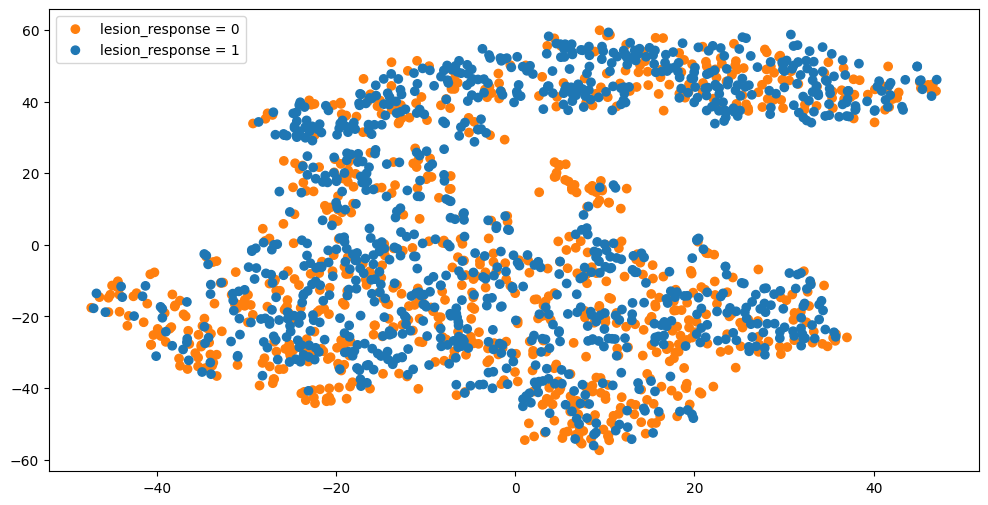

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(df[radiomics.columns])

groupby = 'lesion_response'
colors = {
    0:'tab:orange',
    1:'tab:blue'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


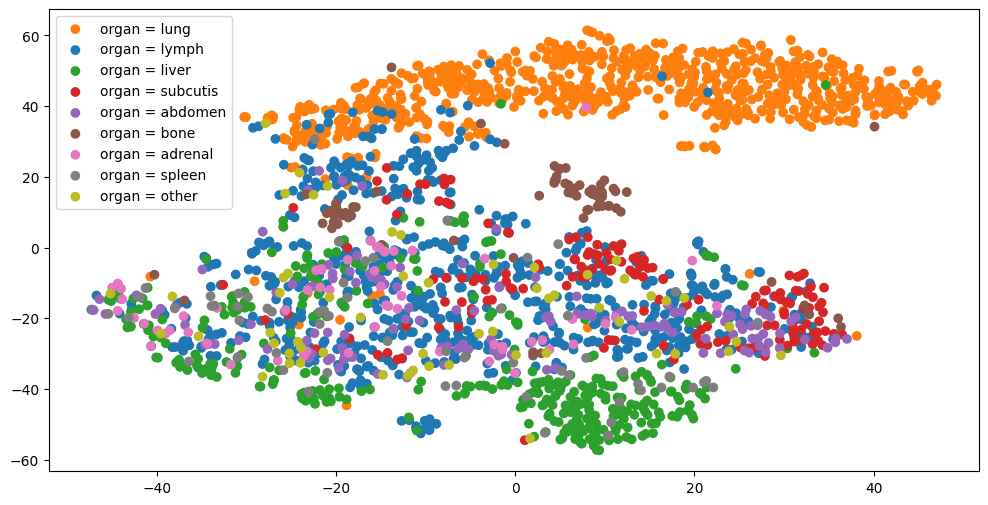

In [29]:
# groupby = 'lesion_response'
# colors = {
#     0:'tab:orange',
#     1:'tab:blue'
# }

groupby = 'organ'
colors = {
    'lung':'tab:orange',
    'lymph':'tab:blue',
    'liver':'tab:green',
    'subcutis':'tab:red',
    'abdomen':'tab:purple',
    'bone':'tab:brown',
    'adrenal':'tab:pink',
    'spleen':'tab:grey',
    'other':'tab:olive'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


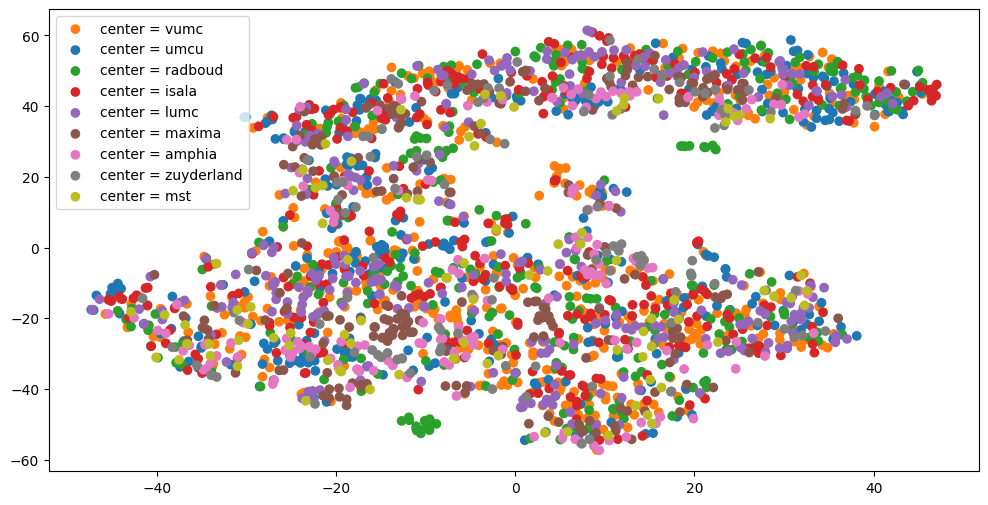

In [30]:
# groupby = 'lesion_response'
# colors = {
#     0:'tab:orange',
#     1:'tab:blue'
# }

groupby = 'center'
colors = {
    'vumc':'tab:orange',
    'umcu':'tab:blue',
    'radboud':'tab:green',
    'isala':'tab:red',
    'lumc':'tab:purple',
    'maxima':'tab:brown',
    'amphia':'tab:pink',
    'zuyderland':'tab:grey',
    'mst':'tab:olive'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

In [18]:
from src.config import dmtr_csv, lesion_level_labels_csv
import pandas as pd

dmtr = pd.read_csv(dmtr_csv).set_index('id')
dmtr = dmtr[dmtr.center != 'umcg']

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';')
lesion_fu = lesion_fu[lesion_fu.center != 'umcg']

dmtr = dmtr.loc[lesion_fu.patient.unique()]

/tmp/ipykernel_7614/3379226976.py:4: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


In [34]:
stables = dmtr[dmtr['Best overall response'] == 'Stable disease']
delta = pd.to_datetime(stables.last_contact) - pd.to_datetime(stables.start_date)

In [53]:
stables[delta.dt.days < 160].index.tolist()

['IM_161',
 'MAX_109',
 'MAX_326',
 'PREM_AM_008',
 'PREM_AM_055',
 'PREM_IS_001',
 'PREM_MS_094',
 'PREM_UMCU_037',
 'PREM_VU_132']

In [61]:
lesion_fu[lesion_fu.patient == 'PREM_VU_132']

,Unnamed: 0,patient,lesion,name,center,baseline,fu1,fu2,fu3,delta1,delta2,delta3,last_fu,lesion_benefit,lesion_response,liver,lung,organ,fold
1665,1665,PREM_VU_132,PREM_VU_132_0.nii.gz,lymph1,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,lymph,0
1666,1666,PREM_VU_132,PREM_VU_132_1.nii.gz,lymph2,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,lymph,0
1667,1667,PREM_VU_132,PREM_VU_132_2.nii.gz,lung1,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,lung,0
1668,1668,PREM_VU_132,PREM_VU_132_3.nii.gz,lung2,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,lung,0
1669,1669,PREM_VU_132,PREM_VU_132_4.nii.gz,subcutis1,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,subcutis,0


In [111]:
grouped = lesion_fu.groupby('patient').last_fu.apply(list)
at_least_one_lesion = lesion_fu[lesion_fu.patient.isin(grouped[grouped.apply(lambda x: pd.isna(x) == False).apply(any)].index)]
no_lesions = lesion_fu[lesion_fu.patient.isin(grouped[grouped.apply(lambda x: pd.isna(x)).apply(all)].index)].patient.unique()
no_lesions = dmtr.loc[no_lesions]
no_lesions = no_lesions[no_lesions.center != 'radboud']

In [119]:
delta = pd.to_datetime(no_lesions.last_contact) - pd.to_datetime(no_lesions.start_date)
early_death = delta[delta.dt.days < 120].index

In [124]:
other = delta[delta.dt.days >= 120].index

In [134]:
len(lesion_fu[lesion_fu.patient.isin(other)])

44

id
MAX_001          2019-09-19
MAX_307          2019-09-27
PREM_AM_065      2017-02-10
PREM_AM_076      2019-04-24
PREM_IS_011      2018-09-20
PREM_LU_108      2019-02-26
PREM_LU_139      2019-12-30
PREM_LU_145      2018-09-13
PREM_LU_483      2017-03-01
PREM_LU_727      2021-03-12
PREM_MS_172      2020-12-01
PREM_UMCU_017    2019-12-20
PREM_UMCU_030    2020-02-06
Name: start_date, dtype: object

In [121]:
len(lesion_fu[lesion_fu.patient.isin(early_death)]) / 2352

0.07865646258503402

In [122]:
len(lesion_fu[lesion_fu.patient.isin(early_death)])

185

In [94]:
at_least_one_lesion.last_fu.isna().sum() / 2352

0.011479591836734694

In [123]:
at_least_one_lesion.last_fu.isna().sum()

27

In [93]:
(lesion_fu.center == 'radboud').sum() / 2352

0.13903061224489796

In [138]:
grouped = lesion_fu.groupby('patient').last_fu.apply(list)
patients_with_missing = grouped[grouped.apply(pd.isna).apply(any)].index

In [144]:
rest = [pt for pt in patients_with_missing if not pt in other and not pt in early_death and not pt in at_least_one_lesion.patient.unique()]

In [148]:
lesion_fu.patient.isin(other).sum() / len(lesion_fu)

0.01870748299319728

In [149]:
lesion_fu.patient.isin(early_death).sum() / len(lesion_fu)

0.07865646258503402

In [153]:
at_least_one_lesion.last_fu.isna().sum() / len(lesion_fu)

0.011479591836734694

In [174]:
len(lesion_fu[~lesion_fu.last_fu.isna()]) / len(lesion_fu)

0.752125850340136

In [158]:
missing_lesions = lesion_fu[lesion_fu.last_fu.isna()]
print(len(missing_lesions[missing_lesions.center == 'radboud']) / len(lesion_fu))

missing_lesions = missing_lesions[missing_lesions.center != 'radboud']

0.13903061224489796


In [161]:
print(len(missing_lesions[missing_lesions.patient.isin(early_death)]) / len(lesion_fu))

missing_lesions = missing_lesions[~missing_lesions.patient.isin(early_death)]

0.07865646258503402


In [165]:
print(len(missing_lesions[missing_lesions.patient.isin(other)]) / len(lesion_fu))

missing_lesions = missing_lesions[~missing_lesions.patient.isin(other)]

0.01870748299319728


In [170]:
len(missing_lesions[missing_lesions.lesion.isin(at_least_one_lesion.lesion.values)]) / len(lesion_fu)

0.011479591836734694

In [172]:
0.011479591836734694 + 0.01870748299319728 + 0.07865646258503402 + 0.13903061224489796

0.24787414965986396

In [176]:
dmtr[dmtr.center == 'isala']

,upn,idaa,gebjaar,Sex,datovl,registratie_id,registratie_upn,datprim,ptloc,typmel,...,dis_date_icu,discharged_to,landQxpBl19EYZK2h5cD,gevtoxsetall,medtoximipi.1,medtoximiipni.1,pabekendch1,episode_nr,age,response
id,,,,,,,,,,,,,,,,,,,,,
PREM_IS_001,1000419630.0,NaN,1961.0,Female,NaN,NaN,NaN,2017-06-12,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,1.0
PREM_IS_002,1000656330.0,NaN,1977.0,Female,NaN,NaN,NaN,2018-03-12,4.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,1.0
PREM_IS_003,1002780090.0,NaN,1944.0,Male,NaN,NaN,NaN,2020-07-02,5.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,1.0
PREM_IS_004,1003044170.0,NaN,1938.0,Male,2020-05-13,NaN,NaN,2013-07-22,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,0.0
PREM_IS_005,1004082120.0,NaN,1944.0,Female,NaN,NaN,NaN,2020-09-10,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PREM_IS_138,2009337083.0,NaN,1951.0,Male,2019-11-06,NaN,NaN,2016-09-12,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.0
PREM_IS_139,2000094693.0,NaN,1961.0,Male,2017-12-20,NaN,NaN,2013-06-05,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,0.0
PREM_IS_140,2001995960.0,NaN,1941.0,Male,NaN,NaN,NaN,2016-09-20,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,0.0
